# **Modeling and Evaluation Classification Predict Multi Engine Notebook**

<span style="color:red"># **IMPORTANT!**</span>  
This notebook has only been "built" up to the stage of the second grid search and also has the following three issues:
* We had to too drop the SmartCorrelatedSelection due to an unresolved issue
* Disappointingly, that grid search appears to have failed (grid_search_summary gave only NaN on min_score, mean_score, max_score and std_score for all estimators).

Because of time constraints and above issues **I have, together with my mentor, decided to leave this notebook in the repo yet to not present this classification study in the dashboard.** Please see Business case for this study in the appendix to the readme.

## Objectives

*   Fit and evaluate a classification model to predict if an airplane have a multi or single engine.


## Inputs

* outputs/datasets/collection/airplane_performance_study.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design/jupyter_notebooks'

Make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design'

---

# Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/airplane_performance_study.csv")
      .drop(labels=['Model', 'Company', 'THR', 'SHP'], axis=1)
                    # target variable for regressor, remove from classifier  
                    # drop other variables we will not need for this project
  )

print(df.shape)
df.head(3)

(857, 21)


,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,AUW,MEW,FW,Vmax,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,False,False,0,2050.0,1180.0,241.2,104.0,...,46.0,370.0,13000.0,13000.0,450.0,450.0,900.0,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,False,False,0,1350.0,820.0,100.5,89.0,...,44.0,190.0,12300.0,12300.0,600.0,600.0,720.0,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,False,False,0,1300.0,810.0,127.3,90.0,...,37.0,210.0,16000.0,16000.0,650.0,650.0,475.0,363.139711,850.0,585.751317


---

# Step 2: ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

Set variables=None to avoid error in first code cell under Handle Target Imbalance!

Below you should include the categorical features to the ordinal_variables and the numerical continous to the yeo_johnson_variables (do not include the target variable, Engine_Type, you deal with that separately!)

"NameError: name 'X' is not defined" will be thrown in the call to below function in a cell under the "Handle Target Imbalance"-headline, further down in this notebook. is most likely due to that the "YeoJohnsonTransformer" transforms X to a Numpy array and that the OrdinalCategoricalEncoder therefore receives a numpy array as input when it requires a pandas dataframe as instead.

Since no solution to this issue was found the workaround here i simply to drop the "SmartCorrelatedSelection" (supposed to come after the "YeoJohnsonTransformer") from the pipeline.


In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import PowerTransformer


def PipelineDataCleaningAndFeatureEngineering():
    """
    Creates a data cleaning and feature engineering pipeline using sklearn and feature-engine.

    This function constructs a machine learning pipeline that performs the following steps:
    1. Applies an Ordinal Encoder to specified categorical variables to convert them into
       ordinal format.
    2. Applies a Yeo-Johnson transformation to specified numerical variables to stabilize
       variance and make the data more Gaussian-like.
    3. Utilizes Smart Correlated Selection to select features based on correlation,
       removing highly correlated variables to reduce multicollinearity.

    Returns:
        Pipeline: A scikit-learn Pipeline object that can be used for fitting and transforming
        data in preparation for modeling.

    Categorical variables:
        - Multi_Engine
        - TP_mods

    Numerical variables for Yeo-Johnson transformation:
        Wing_Span, Length, Height, AUW, MEW, FW, Vmax, Vcruise, Vstall, Range, Hmax, Hmax (One)
        ROC, ROC (One), lo, Slo, Vl, Sl
    """
    # Specify variables for Ordinal Encoder and Power Transformer
    ordinal_variables = ['Multi_Engine', 'TP_mods']

    # Specify the numerical variables for Yeo-Johnson transformation
    yeo_johnson_variables = ['Wing_Span', 'Length', 'Height', 'AUW', 'MEW',
                             'FW', 'Vmax', 'Vcruise', 'Vstall', 'Range',
                             'Hmax', 'Hmax (One)', 'ROC', 'ROC (One)',
                             'Vlo', 'Slo', 'Vl', 'Sl']

    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(variables=ordinal_variables)),

        ("YeoJohnsonTransformer", PowerTransformer(method='yeo-johnson')),
    ])

    return pipeline_base


pipeline = PipelineDataCleaningAndFeatureEngineering()

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    """
    Creates a classification pipeline that includes feature scaling and feature selection.

    This function constructs a machine learning pipeline that performs the following steps:
    1. Scales the features using `StandardScaler` to standardize the dataset, ensuring that 
       each feature contributes equally to the model training.
    2. Applies feature selection using `SelectFromModel` with the provided model to select 
       important features based on their importance weights.
    3. Includes a specified machine learning model for classification.

    Parameters:
        model (estimator): A scikit-learn compatible classifier or ensemble model, such as 
                           LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, 
                           GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, 
                           or XGBClassifier.

    Returns:
        Pipeline: A scikit-learn Pipeline object that can be used for fitting and predicting 
                  with the classification model after preprocessing the data.

    Notes:
        - Ensure that the provided model supports the feature importances method, as 
          `SelectFromModel` will rely on this to determine which features to keep.
    """
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])


    return pipeline_base


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for Hyperparameter Optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


## Split Train and Test Set

Looking at the shapes shows that 80% is taken for a train and the rest (20%) is for test. 

In [8]:
df['Multi_Engine'] = df['Multi_Engine'].astype(object)
df['TP_mods'] = df['TP_mods'].astype(object)
df['Engine_Type'] = df['Engine_Type'].astype(object)

In [9]:
df.head()

,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,AUW,MEW,FW,Vmax,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,False,False,0,2050.0,1180.0,241.2,104.0,...,46.0,370.0,13000.0,13000.0,450.0,450.0,900.0,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,False,False,0,1350.0,820.0,100.5,89.0,...,44.0,190.0,12300.0,12300.0,600.0,600.0,720.0,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,False,False,0,1300.0,810.0,127.3,90.0,...,37.0,210.0,16000.0,16000.0,650.0,650.0,475.0,363.139711,850.0,585.751317
3,35.000000,21.416667,8.583333,False,False,0,1300.0,800.0,127.3,88.0,...,37.0,210.0,13000.0,13000.0,620.0,620.0,500.0,407.797297,850.0,642.046166
4,35.000000,21.416667,8.750000,False,False,0,1220.0,740.0,93.8,83.0,...,33.0,175.0,12500.0,12500.0,370.0,370.0,632.0,297.056192,885.0,329.571813


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Engine_Type'], axis=1),
    df['Engine_Type'],
    test_size=0.2,
    random_state=0,
)
print(df.shape)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# df = pd.DataFrame(y_train.shape)
# print(df.dtypes)


(857, 21)
(685, 20) (685,) (172, 20) (172,)


685 + 172 = 857 perfect result from the split of the data set (75% train and 25% test)!


In [11]:
X_train.head()

,Wing_Span,Length,Height,Multi_Engine,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
196,64.333333,68.416667,20.666667,True,False,48300.0,26985.0,20000.0,546.94,533.6,99.659388,4045.0,41000.0,20000.0,2512.569226,680.0,6969.145819,5684.0,3693.285251,2777.0
645,37.166667,31.166667,10.250000,True,False,5200.0,3229.0,964.8,220.00,197.0,59.000000,620.0,30000.0,18700.0,1530.000000,265.0,1250.000000,820.0,1250.000000,850.0
122,37.666667,25.583333,9.500000,True,False,4880.0,2960.0,750.4,200.00,191.0,66.000000,745.0,19200.0,7600.0,1630.000000,350.0,1700.000000,1255.0,1470.000000,1250.0
851,49.416667,35.083333,14.750000,True,False,6750.0,4350.0,1045.2,198.00,190.0,59.000000,957.0,24000.0,8500.0,1700.000000,340.0,1375.000000,1100.0,1235.000000,865.0
167,34.166667,26.333333,7.333333,False,False,3325.0,2247.0,455.6,174.00,165.0,61.000000,483.0,18200.0,18200.0,1170.000000,1170.0,1420.000000,980.0,1340.000000,835.0


In [12]:
print(df)

     Wing_Span     Length     Height Multi_Engine TP_mods Engine_Type     AUW  \
0    37.416667  25.250000  10.250000        False   False           0  2050.0   
1    36.083333  20.583333   8.750000        False   False           0  1350.0   
2    35.000000  21.416667   8.583333        False   False           0  1300.0   
3    35.000000  21.416667   8.583333        False   False           0  1300.0   
4    35.000000  21.416667   8.750000        False   False           0  1220.0   
..         ...        ...        ...          ...     ...         ...     ...   
852  49.416667  35.083333  14.416667         True   False           0  6250.0   
853  49.000000  35.083333  14.416667         True   False           0  6000.0   
854  44.083333  35.416667  14.416667         True   False           0  5500.0   
855  30.000000  21.166667   7.000000        False   False           0  1817.0   
856  30.000000  21.166667   7.000000        False   False           0  1817.0   

        MEW      FW   Vmax 

In [13]:
print(X_train)

     Wing_Span     Length     Height Multi_Engine TP_mods      AUW      MEW  \
196  64.333333  68.416667  20.666667         True   False  48300.0  26985.0   
645  37.166667  31.166667  10.250000         True   False   5200.0   3229.0   
122  37.666667  25.583333   9.500000         True   False   4880.0   2960.0   
851  49.416667  35.083333  14.750000         True   False   6750.0   4350.0   
167  34.166667  26.333333   7.333333        False   False   3325.0   2247.0   
..         ...        ...        ...          ...     ...      ...      ...   
835  44.083333  43.000000  14.500000         True   False   9400.0   5515.0   
192  61.833333  68.416667  20.666667         True   False  41400.0  18660.0   
629  53.250000  47.250000  14.000000        False   False   9920.0   5732.0   
559  28.750000  20.333333   7.416667        False   False   1750.0   1160.0   
684  36.166667  27.833333   9.500000        False   False   3600.0   2222.0   

          FW    Vmax  Vcruise     Vstall   Range   

In [14]:
print(X_train.dtypes)

Wing_Span       float64
Length          float64
Height          float64
Multi_Engine     object
TP_mods          object
AUW             float64
MEW             float64
FW              float64
Vmax            float64
Vcruise         float64
Vstall          float64
Range           float64
Hmax            float64
Hmax_(One)      float64
ROC             float64
ROC_(One)       float64
Vlo             float64
Slo             float64
Vl              float64
Sl              float64
dtype: object


In [15]:
print(y_train)

196    2
645    0
122    0
851    0
167    0
      ..
835    1
192    2
629    1
559    0
684    0
Name: Engine_Type, Length: 685, dtype: object


In [16]:
print(X_test)

     Wing_Span     Length     Height Multi_Engine TP_mods      AUW      MEW  \
144  32.750000  25.083333   6.500000        False   False   2650.0   1575.0   
774  43.000000  30.083333  11.250000        False   False   4318.0   2900.0   
263  44.083333  36.333333  11.416667         True   False   6850.0   4238.0   
788  44.333333  43.750000  16.000000         True   False  19612.0  10500.0   
846  49.000000  35.083333  14.416667         True   False   6000.0   4250.0   
..         ...        ...        ...          ...     ...      ...      ...   
156  32.750000  25.666667   8.250000        False   False   2750.0   1711.0   
597  36.416667  26.750000   8.333333        False   False   3374.0   2370.0   
624  34.750000  27.416667   8.500000        False   False   3315.0   2000.0   
50   36.750000  29.583333  10.333333         True   False   3800.0   2588.0   
822  36.000000  22.250000   6.500000        False   False   1500.0    990.0   

         FW   Vmax  Vcruise  Vstall   Range     Hma

In [17]:
print(y_test)

144    0
774    1
263    0
788    2
846    0
      ..
156    0
597    0
624    0
50     0
822    0
Name: Engine_Type, Length: 172, dtype: object


In [18]:
df.head()

,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,AUW,MEW,FW,Vmax,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,False,False,0,2050.0,1180.0,241.2,104.0,...,46.0,370.0,13000.0,13000.0,450.0,450.0,900.0,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,False,False,0,1350.0,820.0,100.5,89.0,...,44.0,190.0,12300.0,12300.0,600.0,600.0,720.0,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,False,False,0,1300.0,810.0,127.3,90.0,...,37.0,210.0,16000.0,16000.0,650.0,650.0,475.0,363.139711,850.0,585.751317
3,35.000000,21.416667,8.583333,False,False,0,1300.0,800.0,127.3,88.0,...,37.0,210.0,13000.0,13000.0,620.0,620.0,500.0,407.797297,850.0,642.046166
4,35.000000,21.416667,8.750000,False,False,0,1220.0,740.0,93.8,83.0,...,33.0,175.0,12500.0,12500.0,370.0,370.0,632.0,297.056192,885.0,329.571813


## Handle Target Imbalance

We already see upfront on the Kaggle site for this data that the 'Multi Engine' categorical data is in need of rebalancing


<img src="/workspace/data-driven-design/images_notebook/cat_data_distr_kaggle.png" alt="Information on three categorical features showing the degree of target imbalance" height="200" />


In [19]:
X_train.head(3)

,Wing_Span,Length,Height,Multi_Engine,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
196,64.333333,68.416667,20.666667,True,False,48300.0,26985.0,20000.0,546.94,533.6,99.659388,4045.0,41000.0,20000.0,2512.569226,680.0,6969.145819,5684.0,3693.285251,2777.0
645,37.166667,31.166667,10.250000,True,False,5200.0,3229.0,964.8,220.00,197.0,59.000000,620.0,30000.0,18700.0,1530.000000,265.0,1250.000000,820.0,1250.000000,850.0
122,37.666667,25.583333,9.500000,True,False,4880.0,2960.0,750.4,200.00,191.0,66.000000,745.0,19200.0,7600.0,1630.000000,350.0,1700.000000,1255.0,1470.000000,1250.0


In [20]:
print(type(X_train), type(X_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [21]:
print(X_train.isnull().sum())

Wing_Span       0
Length          0
Height          0
Multi_Engine    0
TP_mods         0
AUW             0
MEW             0
FW              0
Vmax            0
Vcruise         0
Vstall          0
Range           0
Hmax            0
Hmax_(One)      0
ROC             0
ROC_(One)       0
Vlo             0
Slo             0
Vl              0
Sl              0
dtype: int64


In [22]:
print(type(X_train))
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


The call, in below cell, to the "PipelineDataCleaningAndFeatureEngineering()" function upstream in this notebook gives an error (NameError: name 'X' is not defined) **if** the SmartCorrelatedSelection in that function is included. Please see comment above that code cell for more explanation.

In [23]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train, y_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(685, 20) (685,) (172, 20) (172,)


Check Train Set Target distribution

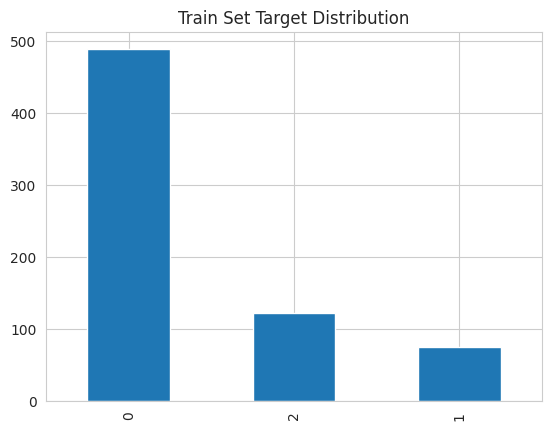

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

Following five codecells takes care of error message with smote. The t_train (target) is an object but with Yes and No however making it to a int64 with 1 and 0 solves it!

In [25]:
print(y_train)

196    2
645    0
122    0
851    0
167    0
      ..
835    1
192    2
629    1
559    0
684    0
Name: Engine_Type, Length: 685, dtype: object


In [26]:
print("Unique labels in y_train:", np.unique(y_train))
print("Data type of y_train:", y_train.dtype)

Unique labels in y_train: [0 1 2]
Data type of y_train: object


In [27]:
y_train = y_train.astype(int)

In [28]:
print("Unique labels in y_train after conversion:", np.unique(y_train))
print("Data type of y_train after conversion:", y_train.dtype)

Unique labels in y_train after conversion: [0 1 2]
Data type of y_train after conversion: int64


In [29]:
print(y_train)

196    2
645    0
122    0
851    0
167    0
      ..
835    1
192    2
629    1
559    0
684    0
Name: Engine_Type, Length: 685, dtype: int64


In [30]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1098, 20) (1098,) (172, 20) (172,)


Check Train Set Target distribution after resampling

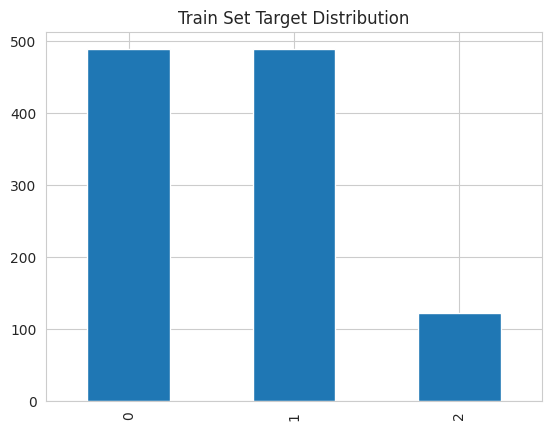

In [31]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm 

In [32]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

Quick GridSearch CV - Binary Classifier

Below cell have long (10 min in my case) execution time (since it is testing a large number of hyperparameters across multiple models and using a computational expensive grid search) however it is not infinite! Alternatively if you want to reduce computational time for the HyperparameterOptimizationSearch function you can:
* Reduce the number of hyperparameters or switch to RandomizedSearchCV.
* Random Forest: Try fewer trees (n_estimators=10 instead of 100), and smaller tree depth (max_depth=5 instead of None).

In [33]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification


Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification

Check results: We note, disappointingly, that gridsearch appears to have failed.

In [34]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,NaN,NaN,NaN,NaN
1,XGBClassifier,NaN,NaN,NaN,NaN
2,DecisionTreeClassifier,NaN,NaN,NaN,NaN
3,RandomForestClassifier,NaN,NaN,NaN,NaN
4,GradientBoostingClassifier,NaN,NaN,NaN,NaN
5,ExtraTreesClassifier,NaN,NaN,NaN,NaN
6,AdaBoostClassifier,NaN,NaN,NaN,NaN


### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [35]:
models_search = {
    "XGBClassifier":XGBClassifier(random_state=0),
}

# documentation to help on hyperparameter list:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "XGBClassifier":{
        'model__learning_rate': [1e-1,1e-2,1e-3],
        'model__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV - Binary Classifier

In [36]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Check results

In [37]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth
0,XGBClassifier,NaN,NaN,NaN,NaN,0.1,3
1,XGBClassifier,NaN,NaN,NaN,NaN,0.1,10
2,XGBClassifier,NaN,NaN,NaN,NaN,0.1,None
3,XGBClassifier,NaN,NaN,NaN,NaN,0.01,3
4,XGBClassifier,NaN,NaN,NaN,NaN,0.01,10
5,XGBClassifier,NaN,NaN,NaN,NaN,0.01,None
6,XGBClassifier,NaN,NaN,NaN,NaN,0.001,3
7,XGBClassifier,NaN,NaN,NaN,NaN,0.001,10
8,XGBClassifier,NaN,NaN,NaN,NaN,0.001,None


Get best model name programmatically

In [38]:
best_model = grid_search_summary.iloc[0,0]
best_model

'XGBClassifier'

Parameters for best model

In [39]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1, 'model__max_depth': 3}

Define the best clf pipeline

In [40]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         gamma=None,
                                                         gpu_id=None,
                                                         importance_type='gain',
                                                         interaction_constraints=None,
                                                         learning_rate=None,
                                                         max_delta_step=None,
                                                         max_depth=None

## Assess feature importance

In [41]:
# Convert X_train (which is a numpy array) to a DataFrame
X_train = pd.DataFrame(X_train)
X_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.839177,1.765869,1.698839,1.040224,0.274505,1.856509,1.842401,1.818269,1.692738,1.832645,1.692988,2.034527,1.363841,0.434620,0.992116,-0.166453,2.081485,2.134575,1.958760,1.723598
1,-0.240682,0.139060,0.008346,1.040224,0.274505,0.123381,0.145992,0.235350,0.257541,0.180991,-0.089035,-0.372700,0.602475,0.237634,0.236785,-1.523499,-0.741767,-0.598004,-0.617318,-0.045816
2,-0.172050,-0.656773,-0.232918,1.040224,0.274505,0.047806,0.043741,0.022025,0.057745,0.116487,0.302293,-0.095566,-0.413384,-1.707131,0.340854,-1.163546,-0.136259,0.038101,-0.259194,0.572699


* With the current model, we can assess with `.features_importances_`

* These are the 5 most important features in descending order. The model was trained on them: 
[7, 8, 15, 0, 14]


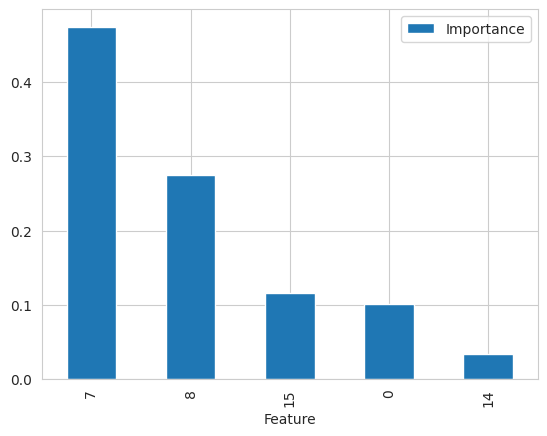

In [42]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


In [43]:
# Access the column names using iloc
nineteenth_column_name = X_train.columns[18]  # 18 corresponds to the 19th column
fifteenth_column_name = X_train.columns[14]    # 14 corresponds to the 15th column

print(f"The name of the 19th column is: {nineteenth_column_name}")
print(f"The name of the 15th column is: {fifteenth_column_name}")


The name of the 19th column is: 18
The name of the 15th column is: 14


In [44]:
# Access the column names using iloc
third_column_name = X_train.columns[2]

print(f"The name of the 3th column is: {third_column_name}")

The name of the 3th column is: 2


## Evaluate Pipeline on Train and Test Sets

In [58]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):
    """
    Evaluates the performance of a classification model by generating a confusion matrix
    and a classification report.

    This function uses the provided pipeline to make predictions on the input features,
    compares these predictions against the true labels, and outputs a confusion matrix
    along with a detailed classification report that includes precision, recall, and F1-score
    for each class.

    Parameters:
        X (array-like or DataFrame): The input features for prediction.
        y (array-like): The true labels corresponding to the input features.
        pipeline (Pipeline): A scikit-learn pipeline object that includes a trained
                             classification model.
        label_map (list): A list of labels corresponding to the classes in `y`, used for
                          labeling the confusion matrix and classification report.

    Outputs:
        Prints:
        - A confusion matrix showing the count of true positive, true negative, false positive,
          and false negative predictions.
        - A classification report detailing the precision, recall, F1-score, and support for
          each class.

    Notes:
        - Ensure that the pipeline has been fitted with training data prior to calling this function.
        - The order of labels in `label_map` should correspond to the order of classes in `y`.
    """
    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=y, y_pred=prediction),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")

def clf_performance(X_train, y_train, pipeline, label_map):
    """
    Evaluates and reports the performance of a classification model on the training set.

    This function prints the confusion matrix and classification report for the training set.

    Parameters:
        X_train (array-like or DataFrame): The input features for the training set.
        y_train (array-like): The true labels for the training set.
        pipeline (Pipeline): A scikit-learn pipeline object that includes a trained
                             classification model.
        label_map (list): A list of labels corresponding to the classes in `y_train`,
                          used for labeling the confusion matrix and classification report.

    Outputs:
        Prints:
        - A confusion matrix and classification report for the training set,
          providing insights into the model's performance in terms of
          accuracy, precision, recall, and F1-score.
    """
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

Evaluation: We cross check with metrics defined at ML business case
* 80% Recall for Multi Engine, on train and test set
* 80% Precision for no Multi Engine on train and test set. 

In [46]:
print(f"Unique classes in y_train: {np.unique(y_train)}")
print(f"Unique classes in y_test: {np.unique(y_test)}")

Unique classes in y_train: [0 1 2]
Unique classes in y_test: [0 1 2]


Adding a non-existent third Engine only with the purpose of solving the dimension mismatch.

In [47]:
# Print all steps in the pipeline to see the names of each step
print(pipeline.named_steps)

{'OrdinalCategoricalEncoder': OrdinalEncoder(variables=['Multi_Engine', 'TP_mods']), 'YeoJohnsonTransformer': PowerTransformer()}


In [59]:
clf_performance(X_train=X_train, y_train=y_train,
                 pipeline=pipeline_clf,
                 label_map=['Single Engine', 'Multi Engine', 'Other Engine'])

#### Train Set #### 

---  Confusion Matrix  ---
                         Actual Single Engine Actual Multi Engine  \
Prediction Single Engine                  488                   0   
Prediction Multi Engine                     0                 488   
Prediction Other Engine                     1                   0   

                         Actual Other Engine  
Prediction Single Engine                   0  
Prediction Multi Engine                    0  
Prediction Other Engine                  121  


---  Classification Report  ---
               precision    recall  f1-score   support

Single Engine       1.00      1.00      1.00       488
 Multi Engine       1.00      1.00      1.00       488
 Other Engine       1.00      0.99      1.00       122

     accuracy                           1.00      1098
    macro avg       1.00      1.00      1.00      1098
 weighted avg       1.00      1.00      1.00      1098
 



In [60]:
print("Unique labels in y_test:", np.unique(y_test))

Unique labels in y_test: [0 1 2]


In [61]:
print("Unique labels in y_test:", np.unique(y_test))


Unique labels in y_test: [0 1 2]


# Step 3: Refit pipeline with best features

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

* However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE().


## Rewrite ML pipeline for Data Cleaning and Feature Engineering

The features have not retained their original column names most likely due to feature reduction. 

In [62]:
best_features

[7, 8, 15, 0, 14]

New Pipeline for DataCleaning And FeatureEngineering

In [63]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=[7, 8, 15, 0, 14])),

    ])

    return pipeline_base


## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [64]:
# Pipeline Optmization: Model
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! We know which features to use already!
        ("model", model),
    ])

    return pipeline_base


## Split Train Test Set, considering only with best features

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Engine_Type'], axis=1),
    df['Engine_Type'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(685, 20) (685,) (172, 20) (172,)


We filter only the most important variables

In [66]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(685, 0) (685,) (172, 0) (172,)


""
196
645
122


Check Train Set Target distribution

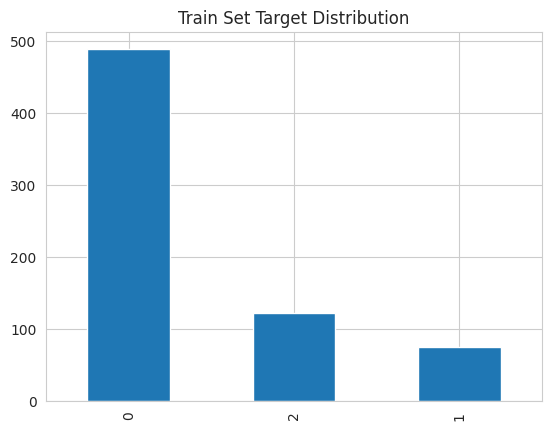

In [68]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from  the last GridCV search

In [71]:
models_search   # XGBClassifier

{'XGBClassifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=0, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None)}

And the best parameters from the last GridCV search 

In [72]:
best_parameters

{'model__learning_rate': 0.1, 'model__max_depth': 3}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [73]:
params_search = {'XGBClassifier':  {
    'model__learning_rate': [0.01],   # the value should be in []
    'model__max_depth': [3]},  # the value should be in []
}
params_search


{'XGBClassifier': {'model__learning_rate': [0.01], 'model__max_depth': [3]}}

Define the best clf pipeline

In [76]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         gamma=None,
                                                         gpu_id=None,
                                                         importance_type='gain',
                                                         interaction_constraints=None,
                                                         learning_rate=None,
                                                         max_delta_step=None,
                                                         max_depth=None

---